In [192]:
## Import libraries
#general
import pandas as pd
import os
import numpy as np
from sklearn import tree
import graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import scipy.stats as stats
import re
from sklearn.externals.six import StringIO


#visualization
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz

In [172]:
## Read in data
data = pd.read_csv('monster_com-job_sample.csv')
data.columns

Index([u'country', u'country_code', u'date_added', u'has_expired',
       u'job_board', u'job_description', u'job_title', u'job_type',
       u'location', u'organization', u'page_url', u'salary', u'sector',
       u'uniq_id'],
      dtype='object')

In [174]:
## Parse salary data and prepare dataset
#data['numbers']=''
data['yearly'] = ''
data['hourly'] =''
data['full_time']=''
data['part_time']=''
data['analyst']=''

for index in data.salary.index:

    #data['numbers'][index]=bool(re.match(r'([0-9]+[^0-9]+)',str(data.salary[index])))
    data['yearly'][index]=bool(re.search('\$ /year',str(data.salary[index])))
    data['hourly'][index]=bool(re.search('\$ /hour',str(data.salary[index])))
    data['full_time'][index]=bool(re.search('Full Time',str(data.job_type[index])))
    data['part_time'][index]=bool(re.search('(part)|(Part)',str(data.job_type[index])))
    data['analyst'][index]=bool(re.search('(analyst)|(Analyst)',str(data.job_title[index])))

#extract salary ranges
ranges=data.salary.str.extract(r'([0-9\.\,\s]+.\-[0-9\.\,\s]+)',expand=True).rename(columns={0:'ranges'})
data=data.join(ranges)

#extract numbers
numbers=data.salary.str.extract(r'([0-9]+\s)',expand=True,).rename(columns={0:'numbers'})
data=data.join(numbers)

#parse salary ranges
df=data['ranges'].str.split('-',expand=True).rename(columns={0:'lowest',1:'highest'})
data=data.join(df)

#convert columns to numeric
numeric=pd.Index([u'lowest',u'highest',u'numbers'])

for i in numeric:
    data[i]=data[i].str.replace(' ','')
    data[i]=data[i].str.replace(',','')
    data[i]=pd.to_numeric(data[i])





In [175]:
#convert units of hours into units of years
for index in data.salary.index:
        for i in numeric:
            if (data.hourly[index]==True):
                if(data.part_time[index]==False):
                    data[i][index]=data[i][index]*40*52
                else:
                   data[i][index]=data[i][index]*20*52

/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [176]:
#get midpoint data for ranges
data['midpoint_salary']=(data['lowest']+data['highest'])/2

#add non-range salaries to midpoints column
for index in data.salary.index:
    if(pd.isnull(data.ranges[index])&pd.notnull(data.numbers[index])):
        data.midpoint_salary[index]=data.numbers[index]

#remove nan's
data=data.dropna(subset=['midpoint_salary'])

#only yearly and hourly salary
data=data[data.yearly|data.hourly]

/Applications/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [177]:
#only include non-bogus salaries. The lowest possible minimum wage job in the US pays at least $7/hour
part_time_min=7*20*52
full_time_min=7*40*52

# filter out any salaries lower than $7/hour
data=data[((data.lowest>=part_time_min)&(data.highest>=part_time_min)&(data.part_time==True))|((data.lowest>=full_time_min)&(data.highest>=full_time_min)&(data.part_time==False))]

# filter out any salaries larger than $9,000,000 a year. Jobs claiming to pay more than that on a job board site would be a bit suspect.
data=data[data.highest<=9000000]

# filter out only salaries in the US, our country of interest.
data=data[data.country_code=='US']

# make states column
states=r'(AK|AL|AR|AZ|CA|CO|CT|DE|FL|GA|HI|IA|ID|IL|IN|KS|KY|LA|MA|MD|ME|MI|MN|MO|MS|MT|NC|ND|NE|NH|NJ|NM|NV|NY|OH|OK|OR|PA|RI|SC|SD|TN|TX|UT|VA|VT|WA|WI|WV|WY)'

state=data.location.str.extract(states,expand=True,).rename(columns={0:'state'})
data=data.join(state)



In [178]:
#fix sector information
i='sector'

data['sector']=data['sector'].str.replace(' ','')
data['sector']=data['sector'].str.replace(',','')


In [179]:
#check min and max salaries
print('max:',data.midpoint_salary.max())
print('min:',data.midpoint_salary.min())
#data.sort_values(by='midpoint_salary',ascending=False)

('max:', 945360.0)
('min:', 9100.0)


In [180]:
# remove data point 7194, as it is highly unlikely that a picker/packer makes $900/hour
data=data.drop(7194)

In [181]:
## Prepare data for linear model and run

#onehotencode variables using dummies and separate out dependent and independent features
df=pd.get_dummies(data[['state','sector']],drop_first=False)
df1=pd.get_dummies(data['part_time'],drop_first=True)
df=df.join(df1)
y=data['midpoint_salary']

#split into training and test set
X_train, X_test, y_train,y_test = train_test_split(df,y,test_size=.22)

#run model
lm=LinearRegression()
lm.fit(X_train,y_train)

print('coefficient: ',lm.coef_)
print('intercept: ',lm.intercept_) 
y_pred_test=lm.predict(X_test)

print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

('coefficient: ', array([  1.04927134e+04,   8.97468255e+03,  -2.24583596e+04,
         8.58186581e+03,  -3.07058700e+03,   1.50148159e+03,
        -6.95754672e+03,  -1.30015231e+04,  -2.26101594e+04,
        -7.30910197e+03,  -1.33939838e+04,   9.23041301e+03,
        -7.76145121e+03,  -4.33700804e+03,   4.75984723e+02,
        -1.99322563e+03,   3.16149595e+04,   2.79287633e+03,
         2.69827755e+03,   4.33135943e+03,   7.06333364e+03,
        -8.34648863e+03,  -5.71444936e+02,  -7.32849995e+04,
         1.69043553e+04,   4.04181044e+04,  -2.23174908e+04,
        -1.41815350e+04,   8.28029211e+03,   1.61109262e+04,
         1.80478569e+03,   1.73307559e+04,  -5.83547311e+03,
        -1.36738755e+04,  -1.16629215e+04,   2.10914894e+03,
        -1.73777113e+04,   4.55311284e+03,  -2.57519213e+04,
        -1.92089091e+04,   4.10655175e+03,   4.10174264e+03,
         4.14696410e+03,   6.24413892e+03,  -7.86250605e+03,
        -9.54028232e+03,   3.44714656e+04,   1.03887240e+17,
      

The linear regression model doesn't seem to work terribly well for this dataset, (at least when you apply it to the whole dataset), even if you include whether or not a job is part-time. Perhaps filtering by the type of position would help.

In [182]:
# only include analyst positions
data2=data[data.analyst==True]


In [183]:
# onehotencode variables using dummies and separate out dependent and independent features
df2=pd.get_dummies(data2[['state','sector']],drop_first=True)
df=pd.get_dummies(data2['part_time'],drop_first=True)
df2=df2.join(df)
y=data2['midpoint_salary']

# Split into training and test set
X_train, X_test, y_train,y_test = train_test_split(df2,y,test_size=.22)

# run model
lm=LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [184]:
# Check the model
print('coefficient: ',lm.coef_)
print('intercept: ',lm.intercept_) 
y_pred_test=lm.predict(X_test)

('coefficient: ', array([  5.62853262e+03,   4.31755573e+03,  -1.87289076e+04,
        -1.53344538e+04,   1.33630924e+04,   9.51445765e+03,
         3.92859729e+04,   1.31332719e+05,   2.36859729e+04,
        -2.65244538e+04,   1.58859729e+04,  -3.06689076e+04,
         3.85143460e+04,   2.29172859e+04,   0.00000000e+00,
         9.47162939e+03,   3.01271848e+04,  -1.45519152e-11,
         7.71308338e+03,   4.33859729e+04,   1.38859729e+04,
         3.16902060e-12,  -6.50261935e+04,  -3.87433653e+04,
        -2.21148805e+04,  -1.30991329e-11,   3.63797881e-12,
        -8.79609244e+03,  -4.56619910e+04,  -6.74000000e+03,
         0.00000000e+00,  -1.53344538e+04,  -1.65419910e+04,
         0.00000000e+00,  -2.65244538e+04]))
('intercept: ', 71228.907639791534)


In [185]:
print("Training set RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
data2.shape

('Training set RMSE:', 154814.47977396622)


(107, 25)

The model is still waaaaaaay off. It seems that number of features is roughly equal to the number of rows. Imputing values is not a good option, since the majority of the dataset is missing plausible values for the thing we want to predict, i.e. salary. Also, since there are  only categorical variables here, linear regression doesn't make sense.

In [208]:
## Use a decision tree to look at what variables are most important

# Try the model using upper and lower ranges rather than midpoint
df3=pd.get_dummies(data[['state','sector']],drop_first=True)
df=pd.get_dummies(data['part_time'],drop_first=True)
df3=df3.join(df)


y2=data['midpoint_salary']

# Split into training and test set
X_train, X_test, y_train,y_test = train_test_split(df3,y2,test_size=.22)

decision_tree = DecisionTreeRegressor(max_depth=6, random_state=1)
decision_tree.fit(X_train,y_train)
print("Decision Tree RMSE:",np.sqrt(metrics.mean_squared_error(y_test,decision_tree.predict(X_test))))

('Decision Tree RMSE:', 32142.853447919435)


('Decision Tree Train/Test RMSE:', 39862.283903281575, ' ', 51237.041857004107)
('Decision Tree Train/Test RMSE:', 38984.143086099379, ' ', 50591.820820955792)
('Decision Tree Train/Test RMSE:', 38353.49913751438, ' ', 49894.856561585904)
('Decision Tree Train/Test RMSE:', 37904.993342841211, ' ', 49523.628886148494)
('Decision Tree Train/Test RMSE:', 37435.399544536791, ' ', 49083.738843821135)
('Decision Tree Train/Test RMSE:', 36971.046366138129, ' ', 49012.53806850913)
('Decision Tree Train/Test RMSE:', 36514.78563436988, ' ', 49302.191210116725)
('Decision Tree Train/Test RMSE:', 36086.117628279877, ' ', 49320.913964857027)
('Decision Tree Train/Test RMSE:', 35663.024050151442, ' ', 49364.56853604802)


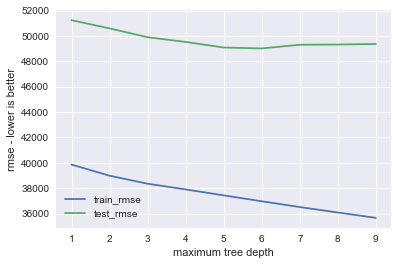

In [199]:
depths = range(1,10)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_rmse = np.sqrt(metrics.mean_squared_error(y_train,decision_tree.predict(X_train)))
    curr_test_rmse = np.sqrt(metrics.mean_squared_error(y_test,decision_tree.predict(X_test)))
    print("Decision Tree Train/Test RMSE:",curr_train_rmse," ",curr_test_rmse)
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.mpl.pyplot.plot(depths,train_rmse,label='train_rmse')
sns.mpl.pyplot.plot(depths,test_rmse,label='test_rmse')
sns.mpl.pyplot.xlabel("maximum tree depth")
sns.mpl.pyplot.ylabel("rmse - lower is better")
sns.mpl.pyplot.legend()

The RMSE is several orders of magnitude lower when using decision trees as compared to linear regression. Therefore, it could be that it's a better fit for this dataset. However, the rmse is still pretty large. One of the issues complicating the matter is that values such as sector seem to have the wrong category of information e.g. Manager, which is not a sector.

In [ ]:
## Can you use sector and location to predict analyst salary range?(using linear regression)
# Transform strings into numbers
#le=LabelEncoder()
#le.fit(data['sector'].unique())
#data['sector_label']=le.transform(data['sector'])
# Encode sector and location with one hot encoder
#enc = OneHotEncoder()
#enc.fit(data.sector_label)
#enc.transform(data.sector_label)




# from: https://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html
categorical_features = ['sector','location']
categorical_names = {}
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data[feature])
    data[feature] = le.transform(data[feature])

en=OneHotEncoder(categorical_features=categorical_features)
en.fit(data)
enc.transform(data)
